In [1]:
import pandas as pd
from scapy.all import *
import binascii
import socket
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [3]:
from scapy.all import rdpcap, TCP, UDP, IP
import pandas as pd
from collections import defaultdict
import statistics
import os
import numpy as np  # needed for np.mean, np.std, np.var

def safe_int(x, default=0):
    try:
        return int(x)
    except Exception:
        return default

def safe_float(x, default=0.0):
    try:
        return float(x)
    except Exception:
        return default

def list_stats(nums):
    """Return (sum, max, min, mean, std) as Python floats/ints for list nums."""
    if not nums:
        return 0.0, 0.0, 0.0, 0.0, 0.0
    s = sum(nums)
    mx = max(nums)
    mn = min(nums)
    mean_v = s / len(nums)
    try:
        std_v = statistics.pstdev(nums)
    except Exception:
        std_v = 0.0
    return safe_float(s), safe_float(mx), safe_float(mn), safe_float(mean_v), safe_float(std_v)

def diffs(sorted_ts):
    """Return list of inter-arrival times (differences) from a sorted list of timestamps."""
    if not sorted_ts or len(sorted_ts) == 1:
        return []
    return [safe_float(t2 - t1) for t1, t2 in zip(sorted_ts[:-1], sorted_ts[1:])]

def get_bulk_stats(lengths, timestamps, iat_threshold=1.0):
    """
    Detect bulk bursts based on inter-arrival time threshold.
    Return average bytes per bulk, average packets per bulk, average bulk rate.
    """
    if not lengths or not timestamps or len(lengths) != len(timestamps):
        return 0, 0, 0

    bursts = []
    current_burst_bytes = 0
    current_burst_packets = 0
    burst_start_time = timestamps[0]

    for i in range(len(timestamps)):
        if i == 0:
            current_burst_bytes = lengths[i]
            current_burst_packets = 1
            burst_start_time = timestamps[i]
        else:
            iat = timestamps[i] - timestamps[i - 1]
            if iat <= iat_threshold:
                current_burst_bytes += lengths[i]
                current_burst_packets += 1
            else:
                burst_duration = timestamps[i - 1] - burst_start_time
                if burst_duration > 0:
                    bulk_rate = current_burst_bytes / burst_duration
                else:
                    bulk_rate = 0
                bursts.append({
                    'bytes': current_burst_bytes,
                    'packets': current_burst_packets,
                    'duration': burst_duration,
                    'rate': bulk_rate
                })
                current_burst_bytes = lengths[i]
                current_burst_packets = 1
                burst_start_time = timestamps[i]

    burst_duration = timestamps[-1] - burst_start_time
    if burst_duration > 0:
        bulk_rate = current_burst_bytes / burst_duration
    else:
        bulk_rate = 0
    bursts.append({
        'bytes': current_burst_bytes,
        'packets': current_burst_packets,
        'duration': burst_duration,
        'rate': bulk_rate
    })

    if not bursts:
        return 0, 0, 0

    avg_bytes_bulk = np.mean([b['bytes'] for b in bursts])
    avg_packets_bulk = np.mean([b['packets'] for b in bursts])
    avg_bulk_rate = np.mean([b['rate'] for b in bursts])

    return safe_int(avg_bytes_bulk), safe_int(avg_packets_bulk), safe_int(avg_bulk_rate)

def extract_flows(pcap_file, only_tcp_udp=True):
    if not os.path.exists(pcap_file):
        raise FileNotFoundError(f"PCAP not found: {pcap_file}")

    packets = rdpcap(pcap_file)
    flows = defaultdict(lambda: {
        "fwd_packet_lengths": [],
        "bwd_packet_lengths": [],
        "fwd_timestamps": [],
        "bwd_timestamps": [],
        "fwd_flags": defaultdict(int),
        "bwd_flags": defaultdict(int),
        "fwd_packets": [],
        "bwd_packets": [],
        "all_packets": []
    })

    for pkt in packets:
        if not pkt.haslayer(IP):
            continue
        ip = pkt[IP]
        proto = safe_int(ip.proto)
        src = ip.src
        dst = ip.dst
        sport = None
        dport = None
        flags = None
        if proto == 6 and pkt.haslayer(TCP):
            sport = safe_int(pkt[TCP].sport)
            dport = safe_int(pkt[TCP].dport)
            flags = pkt[TCP].flags
        elif proto == 17 and pkt.haslayer(UDP):
            sport = safe_int(pkt[UDP].sport)
            dport = safe_int(pkt[UDP].dport)
            flags = None
        else:
            if only_tcp_udp:
                continue
            sport = 0
            dport = 0

        fwd_key = (src, dst, sport, dport, proto)
        bwd_key = (dst, src, dport, sport, proto)

        if fwd_key in flows:
            direction = "fwd"
            key = fwd_key
        elif bwd_key in flows:
            direction = "bwd"
            key = bwd_key
        else:
            direction = "fwd"
            key = fwd_key

        pkt_len = safe_int(len(pkt))
        ts = safe_float(getattr(pkt, "time", 0.0))
        if direction == "fwd":
            flows[key]["fwd_packet_lengths"].append(pkt_len)
            flows[key]["fwd_timestamps"].append(ts)
            flows[key]["fwd_packets"].append(pkt)
            flows[key]["all_packets"].append(pkt)
            if flags is not None:
                try:
                    flows[key]["fwd_flags"][int(flags)] += 1
                except Exception:
                    flows[key]["fwd_flags"]["other"] += 1
        else:
            flows[key]["bwd_packet_lengths"].append(pkt_len)
            flows[key]["bwd_timestamps"].append(ts)
            flows[key]["bwd_packets"].append(pkt)
            flows[key]["all_packets"].append(pkt)
            if flags is not None:
                try:
                    flows[key]["bwd_flags"][int(flags)] += 1
                except Exception:
                    flows[key]["bwd_flags"]["other"] += 1

    rows = []
    for (src, dst, sport, dport, proto), data in flows.items():
        fwd_lens = [safe_int(x) for x in data["fwd_packet_lengths"]]
        bwd_lens = [safe_int(x) for x in data["bwd_packet_lengths"]]
        fwd_ts = sorted([safe_float(x) for x in data["fwd_timestamps"]])
        bwd_ts = sorted([safe_float(x) for x in data["bwd_timestamps"]])
        all_ts = sorted(fwd_ts + bwd_ts)
        (fwd_sum, fwd_max, fwd_min, fwd_mean, fwd_std) = list_stats(fwd_lens)
        (bwd_sum, bwd_max, bwd_min, bwd_mean, bwd_std) = list_stats(bwd_lens)
        fwd_iat_list = diffs(fwd_ts)
        bwd_iat_list = diffs(bwd_ts)
        flow_iat_list = diffs(all_ts)
        def iat_stats(iat_list):
            if not iat_list:
                return 0.0, 0.0, 0.0, 0.0, 0.0
            s = sum(iat_list)
            mn = min(iat_list)
            mx = max(iat_list)
            mean_v = s / len(iat_list)
            std_v = statistics.pstdev(iat_list) if len(iat_list) > 0 else 0.0
            return safe_float(s), safe_float(mean_v), safe_float(std_v), safe_float(mx), safe_float(mn)
        flow_iat_total, flow_iat_mean, flow_iat_std, flow_iat_max, flow_iat_min = iat_stats(flow_iat_list)
        fwd_iat_total, fwd_iat_mean, fwd_iat_std, fwd_iat_max, fwd_iat_min = iat_stats(fwd_iat_list)
        bwd_iat_total, bwd_iat_mean, bwd_iat_std, bwd_iat_max, bwd_iat_min = iat_stats(bwd_iat_list)
        if all_ts:
            flow_duration = safe_int((all_ts[-1] - all_ts[0]) * 1000)
        else:
            flow_duration = 0
        flow_packets = data["all_packets"]
        fwd_packets = data["fwd_packets"]
        bwd_packets = data["bwd_packets"]
        row = {
            "Flow ID": f"{src}-{dst}-{sport}-{dport}-{proto}",
            "Source IP": src,
            "Source Port": safe_int(sport),
            "Destination IP": dst,
            "Destination Port": safe_int(dport),
            "Protocol": safe_int(proto),
            "Timestamp": all_ts[0] if all_ts else 0.0,
            "Flow Duration": flow_duration,
            "Total Fwd Packets": safe_int(len(fwd_lens)),
            "Total Backward Packets": safe_int(len(bwd_lens)),
            "Total Length of Fwd Packets": safe_float(fwd_sum),
            "Total Length of Bwd Packets": safe_float(bwd_sum),
            "Fwd Packet Length Max": safe_float(fwd_max),
            "Fwd Packet Length Min": safe_float(fwd_min),
            "Fwd Packet Length Mean": safe_float(fwd_mean),
            "Fwd Packet Length Std": safe_float(fwd_std),
            "Bwd Packet Length Max": safe_float(bwd_max),
            "Bwd Packet Length Min": safe_float(bwd_min),
            "Bwd Packet Length Mean": safe_float(bwd_mean),
            "Bwd Packet Length Std": safe_float(bwd_std),
            "Flow Bytes/s": safe_float((fwd_sum + bwd_sum) / flow_duration) if flow_duration > 0 else 0,
            "Flow Packets/s": safe_float((len(fwd_packets) + len(bwd_packets)) / flow_duration) if flow_duration > 0 else 0,
            "Flow IAT Mean": safe_float(flow_iat_mean),
            "Flow IAT Std": safe_float(flow_iat_std),
            "Flow IAT Max": safe_float(flow_iat_max),
            "Flow IAT Min": safe_float(flow_iat_min),
            "Fwd IAT Total": safe_float(fwd_iat_total),
            "Fwd IAT Mean": safe_float(fwd_iat_mean),
            "Fwd IAT Std": safe_float(fwd_iat_std),
            "Fwd IAT Max": safe_float(fwd_iat_max),
            "Fwd IAT Min": safe_float(fwd_iat_min),
            "Bwd IAT Total": safe_float(bwd_iat_total),
            "Bwd IAT Mean": safe_float(bwd_iat_mean),
            "Bwd IAT Std": safe_float(bwd_iat_std),
            "Bwd IAT Max": safe_float(bwd_iat_max),
            "Bwd IAT Min": safe_float(bwd_iat_min),
            "Fwd PSH Flags": sum(1 for p in fwd_packets if p.haslayer(TCP) and p[TCP].flags & 0x08),
            "Bwd PSH Flags": sum(1 for p in bwd_packets if p.haslayer(TCP) and p[TCP].flags & 0x08),
            "Fwd URG Flags": sum(1 for p in fwd_packets if p.haslayer(TCP) and p[TCP].flags & 0x20),
            "Bwd URG Flags": sum(1 for p in bwd_packets if p.haslayer(TCP) and p[TCP].flags & 0x20),
            "Fwd Header Length": sum(len(p[TCP]) if p.haslayer(TCP) else len(p[UDP]) for p in fwd_packets),
            "Bwd Header Length": sum(len(p[TCP]) if p.haslayer(TCP) else len(p[UDP]) for p in bwd_packets),
            "Fwd Packets/s": safe_float(len(fwd_packets) / flow_duration) if flow_duration > 0 else 0,
            "Bwd Packets/s": safe_float(len(bwd_packets) / flow_duration) if flow_duration > 0 else 0,
            "Min Packet Length": min([len(p) for p in flow_packets]) if flow_packets else 0,
            "Max Packet Length": max([len(p) for p in flow_packets]) if flow_packets else 0,
            "Packet Length Mean": safe_float(np.mean([len(p) for p in flow_packets])) if flow_packets else 0,
            "Packet Length Std": safe_float(np.std([len(p) for p in flow_packets])) if flow_packets else 0,
            "Packet Length Variance": safe_float(np.var([len(p) for p in flow_packets])) if flow_packets else 0,
            "FIN Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x01),
            "SYN Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x02),
            "RST Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x04),
            "PSH Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x08),
            "ACK Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x10),
            "URG Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x20),
            "CWE Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x80),
            "ECE Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x40),
            "Down/Up Ratio": safe_float(len(bwd_packets) / len(fwd_packets)) if len(fwd_packets) > 0 else 0,
            "Average Packet Size": safe_float((fwd_sum + bwd_sum) / (len(fwd_packets) + len(bwd_packets))) if (len(fwd_packets) + len(bwd_packets)) > 0 else 0,
            "Avg Fwd Segment Size": safe_float(fwd_mean),
            "Avg Bwd Segment Size": safe_float(bwd_mean),
            "Fwd Header Length.1": sum(len(p[TCP]) if p.haslayer(TCP) else len(p[UDP]) for p in fwd_packets),
            "Fwd Avg Bytes/Bulk": get_bulk_stats(fwd_lens, fwd_ts)[0],
            "Fwd Avg Packets/Bulk": get_bulk_stats(fwd_lens, fwd_ts)[1],
            "Fwd Avg Bulk Rate": get_bulk_stats(fwd_lens, fwd_ts)[2],
            "Bwd Avg Bytes/Bulk": get_bulk_stats(bwd_lens, bwd_ts)[0],
            "Bwd Avg Packets/Bulk": get_bulk_stats(bwd_lens, bwd_ts)[1],
            "Bwd Avg Bulk Rate": get_bulk_stats(bwd_lens, bwd_ts)[2],
            "Subflow Fwd Packets": safe_int(len(fwd_packets)),
            "Subflow Fwd Bytes": safe_int(fwd_sum),
            "Subflow Bwd Packets": safe_int(len(bwd_packets)),
            "Subflow Bwd Bytes": safe_int(bwd_sum),
            "Init_Win_bytes_forward": fwd_packets[0][TCP].window if (fwd_packets and fwd_packets[0].haslayer(TCP)) else 0,
            "Init_Win_bytes_backward": bwd_packets[0][TCP].window if (bwd_packets and bwd_packets[0].haslayer(TCP)) else 0,
            "act_data_pkt_fwd": sum(1 for p in fwd_packets if len(p) > 0),
            "min_seg_size_forward": min([len(p) for p in fwd_packets]) if fwd_packets else 0
        }
        if len(all_ts) > 1:
            gaps = np.diff(sorted(all_ts))
            active_times = gaps[gaps <= 1]
            idle_times = gaps[gaps > 1]
            row["Active Mean"] = safe_float(np.mean(active_times)) if len(active_times) else 0
            row["Active Std"] = safe_float(np.std(active_times)) if len(active_times) else 0
            row["Active Max"] = safe_float(np.max(active_times)) if len(active_times) else 0
            row["Active Min"] = safe_float(np.min(active_times)) if len(active_times) else 0
            row["Idle Mean"] = safe_float(np.mean(idle_times)) if len(idle_times) else 0
            row["Idle Std"] = safe_float(np.std(idle_times)) if len(idle_times) else 0
            row["Idle Max"] = safe_float(np.max(idle_times)) if len(idle_times) else 0
            row["Idle Min"] = safe_float(np.min(idle_times)) if len(idle_times) else 0
        else:
            row["Active Mean"] = row["Active Std"] = row["Active Max"] = row["Active Min"] = 0
            row["Idle Mean"] = row["Idle Std"] = row["Idle Max"] = row["Idle Min"] = 0
        rows.append(row)
    df = pd.DataFrame(rows)
    return df

if __name__ == "__main__":
    pcap_path = r"C:\Users\NSHAT\crossrealms - intern\honeypot - final AI engine\data\honeypot_capture1.pcap"
    df1 = extract_flows(pcap_path)
    print(df1.dtypes)


Flow ID              object
Source IP            object
Source Port           int64
Destination IP       object
Destination Port      int64
                     ...   
Active Min          float64
Idle Mean           float64
Idle Std            float64
Idle Max            float64
Idle Min            float64
Length: 84, dtype: object


In [4]:
df2 = extract_flows(r"C:\Users\NSHAT\crossrealms - intern\honeypot - final AI engine\data\honeypot_capture2.pcap")

In [5]:
df1.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,10.0.1.4-141.140.238.27-64295-58915-6,10.0.1.4,64295,141.140.238.27,58915,6,1.754587e+09,525843,25,33,...,25,66,0.027600,0.040858,0.178251,0.000000,104.881608,30.434039,120.100218,44.013529
1,147.185.132.18-10.0.1.4-65168-135-6,147.185.132.18,65168,10.0.1.4,135,6,1.754587e+09,10103,4,2,...,4,66,0.025507,0.043951,0.101632,0.000000,10.001136,0.000000,10.001136,10.001136
2,35.203.211.121-10.0.1.4-51256-45343-6,35.203.211.121,51256,10.0.1.4,45343,6,1.754587e+09,10,2,1,...,2,60,0.005055,0.003693,0.008748,0.001361,0.000000,0.000000,0.000000,0.000000
3,176.65.148.65-10.0.1.4-57121-5005-6,176.65.148.65,57121,10.0.1.4,5005,6,1.754587e+09,11,2,1,...,2,60,0.005853,0.004787,0.010640,0.001066,0.000000,0.000000,0.000000,0.000000
4,20.102.116.62-10.0.1.4-49481-5984-6,20.102.116.62,49481,10.0.1.4,5984,6,1.754587e+09,82,2,1,...,2,60,0.041260,0.040271,0.081530,0.000989,0.000000,0.000000,0.000000,0.000000


In [6]:
df2.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,10.0.1.4-141.140.238.27-64295-58915-6,10.0.1.4,64295,141.140.238.27,58915,6,1.754588e+09,601083,11,12,...,11,66,0.044319,0.053207,0.138482,0.000000,120.065938,0.045396,120.099432,119.980061
1,104.238.194.12-10.0.1.4-51610-22243-6,104.238.194.12,51610,10.0.1.4,22243,6,1.754588e+09,1127,3,3,...,3,66,0.031661,0.054746,0.126484,0.000000,1.001110,0.000000,1.001110,1.001110
2,10.0.1.4-192.81.131.223-3388-45196-6,10.0.1.4,3388,192.81.131.223,45196,6,1.754588e+09,172,3,2,...,3,54,0.043214,0.074739,0.172665,0.000000,0.000000,0.000000,0.000000,0.000000
3,192.81.131.223-10.0.1.4-45208-3388-6,192.81.131.223,45208,10.0.1.4,3388,6,1.754588e+09,1303,5,5,...,5,60,0.037722,0.061941,0.144905,0.000054,1.002057,0.000000,1.002057,1.002057
4,10.0.1.4-168.63.129.16-59800-80-6,10.0.1.4,59800,168.63.129.16,80,6,1.754588e+09,5,5,4,...,5,66,0.000647,0.001151,0.003645,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
df = pd.concat([df1, df2], ignore_index=True)

In [8]:
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,10.0.1.4-141.140.238.27-64295-58915-6,10.0.1.4,64295,141.140.238.27,58915,6,1.754587e+09,525843,25,33,...,25,66,0.027600,0.040858,0.178251,0.000000,104.881608,30.434039,120.100218,44.013529
1,147.185.132.18-10.0.1.4-65168-135-6,147.185.132.18,65168,10.0.1.4,135,6,1.754587e+09,10103,4,2,...,4,66,0.025507,0.043951,0.101632,0.000000,10.001136,0.000000,10.001136,10.001136
2,35.203.211.121-10.0.1.4-51256-45343-6,35.203.211.121,51256,10.0.1.4,45343,6,1.754587e+09,10,2,1,...,2,60,0.005055,0.003693,0.008748,0.001361,0.000000,0.000000,0.000000,0.000000
3,176.65.148.65-10.0.1.4-57121-5005-6,176.65.148.65,57121,10.0.1.4,5005,6,1.754587e+09,11,2,1,...,2,60,0.005853,0.004787,0.010640,0.001066,0.000000,0.000000,0.000000,0.000000
4,20.102.116.62-10.0.1.4-49481-5984-6,20.102.116.62,49481,10.0.1.4,5984,6,1.754587e+09,82,2,1,...,2,60,0.041260,0.040271,0.081530,0.000989,0.000000,0.000000,0.000000,0.000000


In [9]:
df.shape

(2087, 84)

In [10]:
df.columns

Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
  

In [11]:
df['Protocol'].unique()

array([ 6, 17])

In [12]:
# SAVED TO CSV FILE 

# First Approach : Clustreing to Label the Data

In [82]:

top_features = [
      'Flow Bytes/s',
       'Flow Packets/s',
    'Flow Duration',
     'Down/Up Ratio',
     'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
      'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean',
    "Bwd Packet Length Mean",
    "Avg Bwd Segment Size", "Average Packet Size","Flow IAT Max",
    "Bwd Packet Length Max",
    "Idle Mean",
    "Fwd IAT Max"
]

X = df[top_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


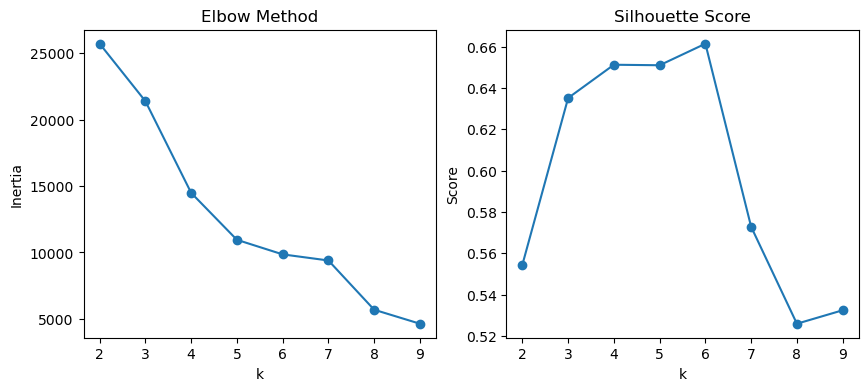

In [83]:
inertias = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.show()
# to check wahts the best k value

In [84]:
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [102]:
cluster_summary = df.groupby('Cluster')[top_features].mean()
cluster_summary.head()

,Flow Bytes/s,Flow Packets/s,Flow Duration,Down/Up Ratio,Min Packet Length,Max Packet Length,Packet Length Mean,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Mean,Avg Bwd Segment Size,Average Packet Size,Flow IAT Max,Bwd Packet Length Max,Idle Mean,Fwd IAT Max
Cluster,,,,,,,,,,,,,,,,,
0,112.191248,0.738336,2176.186335,0.826101,66.060041,267.196687,107.905084,258.748102,66.873016,122.025624,88.930006,88.930006,107.905084,0.833219,137.703934,0.630256,0.642910
1,2034.992758,5.492947,360.922794,0.676677,69.838235,1502.132353,338.413268,1501.750000,69.926471,475.518246,123.575316,123.575316,338.413268,0.108908,325.823529,0.093866,0.116485
2,557.990407,1.588845,399.723164,0.823862,65.751412,1461.824859,357.396688,438.460452,65.819209,157.210368,604.294378,604.294378,357.396688,0.248346,1461.824859,0.202000,0.250761
3,0.010566,0.000054,390849.833333,0.837862,66.000000,930.833333,204.391121,726.166667,66.000000,220.767963,178.844968,178.844968,204.391121,316.944937,426.333333,315.673928,316.945163


In [ ]:
'''
Cluster	Traffic Type                  	Malicious?	        Possible Attack Type
0	Normal background               	No	BENIGN
1	High-volume download/streaming	    Usually No	        BENIGN (bulk traffic)
2	Upload-heavy / asymmetric flows	    Yes                	Data exfiltration / C2 communication
3	Very long, idle, tiny traffic	    Yes	                Scanning / beaconing / probe

'''

C:\Users\NSHAT\AppData\Local\Temp\ipykernel_12312\2637313385.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 4)


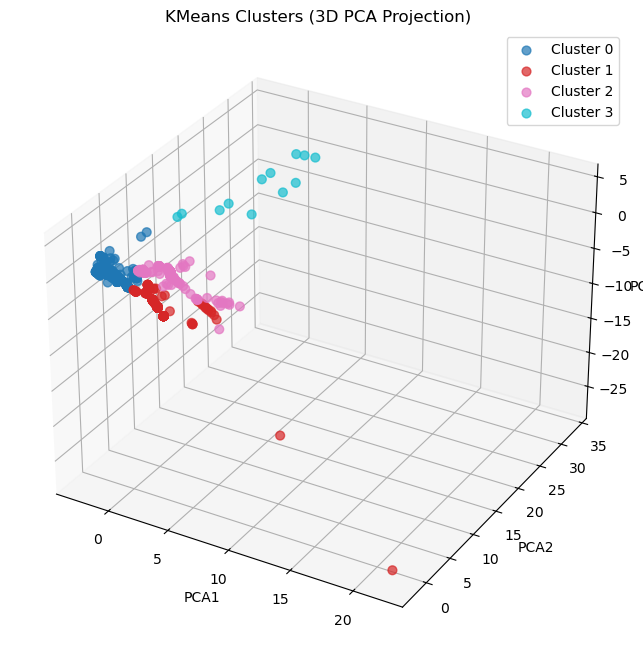

In [86]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_scaled)
df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]
df["PCA3"] = pca_result[:, 2]

# Plotting 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.get_cmap('tab10', 4)

for cluster in range(4):
    cluster_data = df[df["Cluster"] == cluster]
    ax.scatter(
        cluster_data["PCA1"], cluster_data["PCA2"], cluster_data["PCA3"],
        label=f"Cluster {cluster}",
        s=40,
        alpha=0.7,
        color=colors(cluster)
    )

ax.set_title("KMeans Clusters (3D PCA Projection)")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.legend()
plt.show()

In [87]:
cluster_counts = df['Cluster'].value_counts().sort_index()
print(cluster_counts.reset_index().rename(columns={'index': 'Cluster', 'Cluster': 'Count'}))

   Count  count
0      0   1449
1      1    272
2      2    354
3      3     12


In [90]:
labels =df['Cluster']
score = silhouette_score(X_scaled, labels)
print(score)

0.6513215719315598


# Second Approach: Using a Pre Trained model to predict labels for our data

### the model used for predictions achived 0.99 accuracy and is trained on CIC-IDS-2017 dataset

In [69]:
df_labeled= pd.read_csv(r"C:\Users\NSHAT\crossrealms - intern\honeypot - final AI engine\honeypot-data-labeled.csv")

In [70]:
df_labeled.shape

(2087, 85)

In [71]:
df_labeled["Predicted_Label"].unique()

array(['BENIGN', 'SSH-Patator', 'DoS Slowhttptest'], dtype=object)

In [72]:
df_labeled["Predicted_Label"].value_counts()

Predicted_Label
BENIGN              2081
DoS Slowhttptest       4
SSH-Patator            2
Name: count, dtype: int64

In [ ]:
# not great for training a model

# Training a Model Based on the cluster labels

In [91]:
feature_cols = [col for col in df.columns if col not in 
                ['Flow ID', 'Source IP', 'Destination IP', 
                 'Source Port', 'Destination Port', 'Timestamp', 'Cluster']]

X = df[feature_cols]
y = df['Cluster'] 

In [104]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV

model = RandomForestClassifier(n_estimators=100, random_state=42)

scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())


Cross-validation scores: [0.99760766 0.99760766 0.99520384 0.99760192 0.99040767]
Mean accuracy: 0.9956857480522758


In [97]:
y_pred = cross_val_predict(model, X, y, cv=kf)

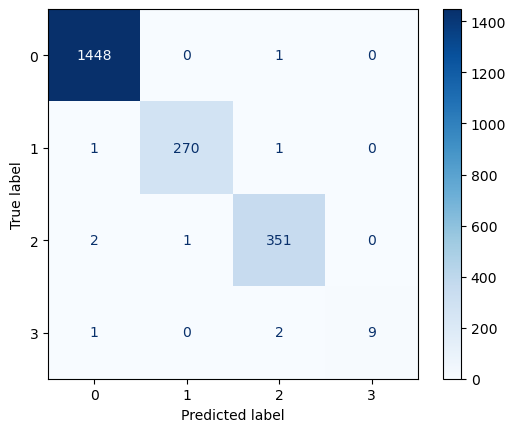

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [105]:
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.9957
Recall:    0.9957
F1 Score:  0.9956
